In [1]:
from sae_core.analysis import SAEAnalyzer
from sae_core.pretrained import PRETRAINED_SAES, list_pretrained, load_pretrained
from sae_core.data_processing.textbook_process import load_processed_data
from transformer_lens import HookedTransformer
import numpy as np

/home/ubuntu/sae_env/lib/python3.10/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/home/ubuntu/sae_env/lib/python3.10/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type ali

In [2]:
qwen3_06B_sae_file_path = list_pretrained()[-1]
qwen3_06B_SAE, history = load_pretrained(qwen3_06B_sae_file_path, load_history=True)
qwen3_06B_sae_file_path, qwen3_06B_SAE

/home/ubuntu/sae_core/sae_base.py:146: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(path / "weights.pt", map_location=device)


('qwen3_06B.blocks.12.hook_resid_post.sae.sparsity40.mse0.001.kl0.01',
 SAE(
   (hook_sae_input): HookPoint()
   (hook_sae_acts_pre): HookPoint()
   (hook_sae_acts_post): HookPoint()
   (hook_sae_output): HookPoint()
   (hook_sae_recons): HookPoint()
 ))

In [3]:
qwen3_06B = HookedTransformer.from_pretrained("qwen3-0.6b")

`torch_dtype` is deprecated! Use `dtype` instead!


Loaded pretrained model qwen3-0.6b into HookedTransformer


In [4]:
chemistry_texts = load_processed_data('sae_core/data/processed_data/processed_chem_text.json')

In [5]:
hook_layer = '12'
hook_name = 'hook_resid_post'
qwen3_analyzer = SAEAnalyzer(qwen3_06B, qwen3_06B_sae_file_path, hook_layer, hook_name, chemistry_texts)

✓ Loaded SAE from qwen3_06B.blocks.12.hook_resid_post.sae.sparsity40.mse0.001.kl0.01
✓ Model and SAE on device: cuda:0
✓ Hook point: blocks.12.hook_resid_post
✓ SAE dimensions: 1024 → 4096
✓ Dataset: 3437 texts


In [6]:
qwen3_analyzer.hook_point

'blocks.12.hook_resid_post'

In [7]:
# Check:
print(f"Encoder bias mean: {qwen3_analyzer.sae.b_enc.mean()}")
print(f"Decoder bias norm: {qwen3_analyzer.sae.b_dec.norm()}")

print(f"Encoder weight mean: {qwen3_analyzer.sae.W_enc.mean()}")
print(f"Decoder weight norm: {qwen3_analyzer.sae.W_dec.norm()}")

Encoder bias mean: -0.025613131001591682
Decoder bias norm: 0.986893892288208
Encoder weight mean: -4.2854517232626677e-05
Decoder weight norm: 64.0


In [8]:
paragraph_lengths = [len(par) for par in chemistry_texts]
lower_quartile = np.quantile(paragraph_lengths, 0.25)
upper_quartile = np.quantile(paragraph_lengths, 0.75)
mean = np.mean(paragraph_lengths)
median = np.median(paragraph_lengths)
lower_quartile, upper_quartile, mean, median

(28.0, 314.0, 213.84870526622055, 113.0)

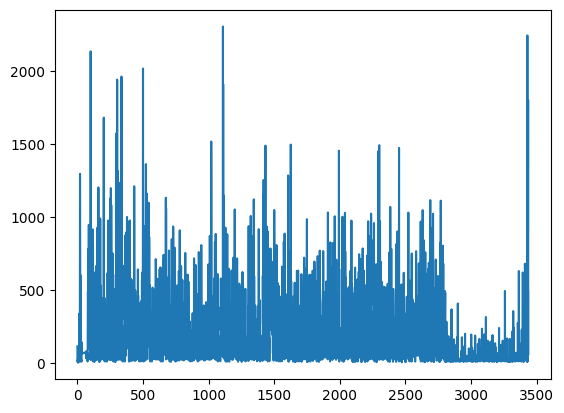

In [9]:
import matplotlib.pyplot as plt
plt.plot(paragraph_lengths)

In [10]:
large_text_list = [par for  par in chemistry_texts if len(par)>mean]
len(large_text_list)

1207

In [11]:
# Debug your dataset
print(f"Dataset size: {len(large_text_list[48:64])}")
for i, text in enumerate(large_text_list[48:64]):
    print(f"Text {i}: len={len(text)}, preview={text[:50]}")

Dataset size: 16
Text 0: len=283, preview=School-teacher, theologian, philosopher, scientist
Text 1: len=516, preview=The evolution of the oxygen begins at about 400°. 
Text 2: len=664, preview=~Directions for preparing oxygen.~ The manner of p
Text 3: len=244, preview=In the preparation of oxygen from potassium chlora
Text 4: len=277, preview=~The collection of gases.~ The method used for col
Text 5: len=405, preview=~Commercial methods of preparation.~ Oxygen can no
Text 6: len=563, preview=~Physical properties.~ Oxygen is a colorless, odor
Text 7: len=851, preview=~Chemical properties.~ At ordinary temperatures ox
Text 8: len=476, preview=The burning of a substance in oxygen is due to the
Text 9: len=795, preview=~Oxidation.~ The term _oxidation_ is applied to th
Text 10: len=929, preview=~Combustion; kindling temperature.~ When oxidation
Text 11: len=610, preview=~Oxides.~ The compounds formed by the oxidation of
Text 12: len=565, preview=~Products of combustion.~ The particular ox

In [12]:
# 1. Are activations centered properly?
import torch
tokens = large_text_list[0]
with torch.no_grad():
    _, cache = qwen3_06B.run_with_cache(tokens)
    acts = cache[f'blocks.{hook_layer}.{hook_name}']
    print(f"Activation mean: {acts.mean():.4f}")
    print(f"Activation std: {acts.std():.4f}")
    print(f"Activation range: [{acts.min():.4f}, {acts.max():.4f}]")

# 2. Check decoder norm during training
print(f"Decoder Frobenius norm: {torch.norm(qwen3_06B_SAE.W_dec):.4f}")
print(f"Expected: {np.sqrt(qwen3_06B_SAE.cfg.d_sae):.4f}")

# 3. Check if features are actually sparse
features = qwen3_06B_SAE.encode(acts.flatten(0, 1).to(qwen3_06B_SAE.device))
print(f"Feature sparsity: {(features == 0).float().mean():.4f}")  # Should be >0.9
print(f"L0 (features/token): {(features > 0).float().sum(dim=1).mean():.2f}")

Activation mean: 0.1165
Activation std: 24.1084
Activation range: [-166.3931, 6836.2837]
Decoder Frobenius norm: 63.9946
Expected: 64.0000
Feature sparsity: 0.9607
L0 (features/token): 161.02


Final epoch metrics:
  Loss: 3.2783
  Recon Loss: 0.6668
  L1 Loss: 0.0554
  Sparsity (L0): 41.39


/tmp/ipykernel_16786/3042681595.py:36: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


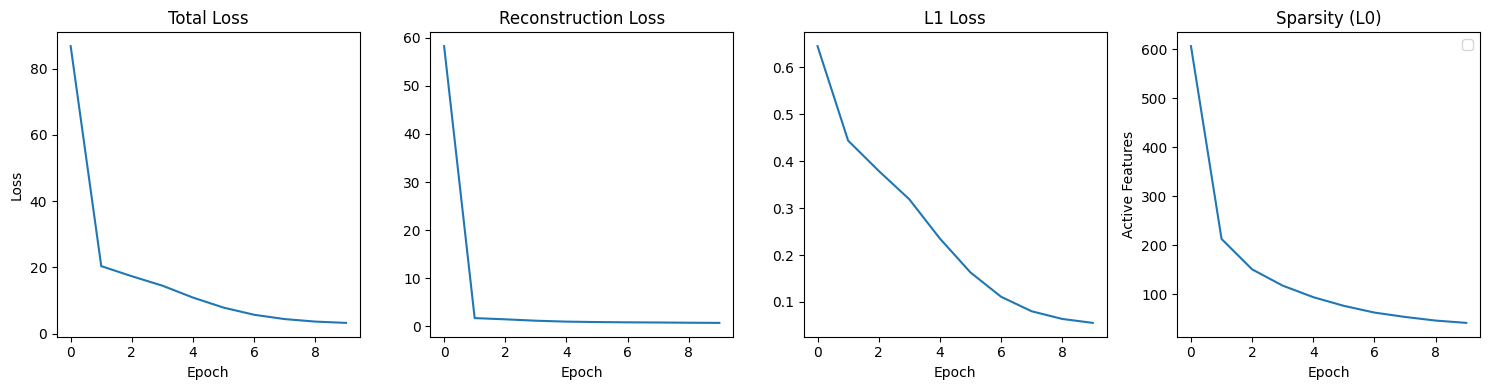

In [13]:
import matplotlib.pyplot as plt

# Load your training history
print(f"Final epoch metrics:")
print(f"  Loss: {history['loss'][-1]:.4f}")
print(f"  Recon Loss: {history['recon_loss'][-1]:.4f}")
print(f"  L1 Loss: {history['l1_loss'][-1]:.4f}")
print(f"  Sparsity (L0): {history['sparsity'][-1]:.2f}")

# Plot training curves
plt.figure(figsize=(15, 4))

plt.subplot(1, 4, 1)
plt.plot(history['loss'])
plt.title('Total Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 4, 2)
plt.plot(history['recon_loss'])
plt.title('Reconstruction Loss')
plt.xlabel('Epoch')

plt.subplot(1, 4, 3)
plt.plot(history['l1_loss'])
plt.title('L1 Loss')
plt.xlabel('Epoch')

plt.subplot(1, 4, 4)
plt.plot(history['sparsity'])
# plt.axhline(y=100, color='g', linestyle='--', label='Target ~100')
# plt.axhline(y=50, color='b', linestyle='--', label='Good <50')
plt.title('Sparsity (L0)')
plt.xlabel('Epoch')
plt.ylabel('Active Features')
plt.legend()

plt.tight_layout()
plt.show()

In [14]:
analyzer = SAEAnalyzer(
    model=qwen3_06B,
    sae_path=qwen3_06B_sae_file_path,
    layer=f'{hook_layer}',
    hook_name=f'{hook_name}',
    dataset=large_text_list#[48:64]
)

results = analyzer.run_full_analysis(
    batch_size=8,
    save_path='analysis_results.json'
)

# Find interesting examples
examples = analyzer.find_max_activating_examples(feature_idx=99, top_k=10)

/home/ubuntu/sae_core/sae_base.py:146: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(path / "weights.pt", map_location=device)


✓ Loaded SAE from qwen3_06B.blocks.12.hook_resid_post.sae.sparsity40.mse0.001.kl0.01
✓ Model and SAE on device: cuda:0
✓ Hook point: blocks.12.hook_resid_post
✓ SAE dimensions: 1024 → 4096
✓ Dataset: 1207 texts

Running Full SAE Analysis


[1/4] Computing Sparsity Metrics...
Computing sparsity metrics on 1207 texts...


Sparsity: 100%|██████████| 151/151 [00:27<00:00,  5.43it/s]



✓ Sparsity Results:
  L0: 58.97 ± 95.26 features/token
  L1: 139.8007 ± 663.0794
  Tokens processed: 260594

[2/4] Identifying Dead Features...

✓ Dead Features (threshold=0.01):
  2449/4096 (59.8%) dead features

[3/4] Computing Reconstruction Metrics...
Computing reconstruction metrics on 1207 texts...


Reconstruction: 100%|██████████| 151/151 [00:28<00:00,  5.39it/s]



✓ Reconstruction Results:
  MSE: 0.633722
  Explained Variance: 0.9972 (99.72%)
  Cosine Similarity: 0.8563
  Tokens processed: 260594

[4/4] Running Ablation Study...
Running ablation study on 1207 texts...


Ablation: 100%|██████████| 302/302 [01:24<00:00,  3.55it/s]



✓ Ablation Study Results:
  Baseline Loss:      3.0453
  Zero Ablation:      11.9312 (+8.8860)
  SAE Reconstruction: 3.8014 (+0.7561)
  Loss Recovered:     91.49%
  Batches processed:  302

✓ Results saved to analysis_results.json

Analysis Complete!

Finding max activating examples for feature 99...


Max Act: 100%|██████████| 151/151 [00:29<00:00,  5.17it/s]


✓ Found top 10 activating examples for feature 99
  Max activation: 2.4277
  Min activation (in top-k): 1.0485


In [20]:
examples

[{'text': " well as the water formed, were all accurately\nweighed. According to Morley's results, ",
  'target_token': 'weigh',
  'activation': 2.4276628494262695,
  'position': 59,
  'batch_idx': 129},
 {'text': ' empty flask is subtracted from\n     these two weighings, the relative weights of the gases is\n',
  'target_token': ' weigh',
  'activation': 1.9458143711090088,
  'position': 126,
  'batch_idx': 627},
 {'text': ' By referring to the periodic arrangement of the elements\n(page 168), it will be seen that',
  'target_token': '(page',
  'activation': 1.8877203464508057,
  'position': 16,
  'batch_idx': 994},
 {'text': 'ELTING |___________________\n        |        | WEIGHT |         |  POINT  |          |\n       ',
  'target_token': ' WEIGHT',
  'activation': 1.8059601783752441,
  'position': 52,
  'batch_idx': 993},
 {'text': '| CARBONATE\n          |        | WEIGHT |         |         |        | DECOMPOSE',
  'target_token': ' WEIGHT',
  'activation': 1.694390892982483,
 

In [15]:
results.keys()

dict_keys(['sparsity', 'feature_freq', 'dead_features', 'reconstruction', 'ablation'])

In [16]:
results['sparsity']

{'l0_mean': 58.96791944557434,
 'l0_std': 95.25740600337474,
 'l1_mean': 139.80072716682847,
 'l1_std': 663.0794465796048,
 'n_features': 4096,
 'n_tokens': 260594}

In [17]:
results['ablation']

{'baseline_loss': 3.045258078354084,
 'zero_ablation_loss': 11.931215589409632,
 'sae_reconstruction_loss': 3.8013515819776926,
 'loss_recovered': 0.9149114203300086,
 'n_batches': 302}

In [18]:
# hook_names = list(qwen3_06B.hook_dict.keys())
# for name in hook_names:
#     print(name)

In [19]:
qwen3_06B_14_mlp_SAE, qwen3_06B_14_mlp_SAE_history = load_pretrained(qwen3_06B_l14_mlp_file_path, load_history=True)

NameError: name 'qwen3_06B_l14_mlp_file_path' is not defined